In [1]:
#Purpose of this is simply to see if 2d sampling is working, with plots etc

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import inspect
import numpy as np

In [3]:
import ipytest
ipytest.autoconfig()
import pytest

In [4]:
Normal_density = lambda x: torch.exp(Normal.log_prob(x))
N=10
zdim=2
Particles = torch.rand(N,zdim) #so dim=2

In [4]:
def norm2(X):
    """"Vectorized implementation of norm squared. X is collection of N x,y points, and
        returns Y, where Y[i,j] = norm(X[i],X[j])**2. X has shape N*zdim, Y has shape NxN.
    """
    
    #Use formula ||(x-y)||**2 = ||x||**2 + ||y||**2 - 2x.T*y. in 1d this is just the 
    #familiar formula (x-y)**2 expanded. 
    
    X_norm = torch.sum(X ** 2, axis = -1) #gives x[i]**2 for each i

    #This First part is "matrix mult" viewed as addition
    tem1 = X_norm[:,None] + X_norm[None,:] #gives x[i]**2 + x[j]**2 for each i,j
 
    tem2 = - 2 * torch.mm(X, X.T) #last part of above formula
    
    return tem1 + tem2
        
    

In [6]:
%%ipytest -qq

@pytest.mark.parametrize('i,j,N,zdim',
[(0,0,1,1),(1,1,10,1),(2,3,15,2)])

def test1_norm2(i,j,N,zdim):
    """Test norm2 function above with several different values of: N=number of particles,zdim=dim of each 
        particle and i,j the index."""
    
    X = torch.rand(N,zdim)

    assert norm2(X)[i,j] - torch.linalg.vector_norm(X[i]-X[j])**2 < 1e-06
    
    
    

...                                                                                          [100%]


In [5]:
def rbf(NORM2,sig=1.0):
    """"Assumes have already computed norm2(X). So can call as: rbf(norm2(X),sig)
    """
    
    assert(sig>0)
    assert NORM2.shape[0] == NORM2.shape[1]
    
    return torch.exp(-1/(2*sig)*NORM2)
    

In [8]:
%%ipytest -qq

@pytest.mark.parametrize('i,j,N,zdim,sig',
[(0,0,1,1,1.0),(1,1,10,1,0.5),(2,3,15,2,1.01)])

def test1_rbf(i,j,N,zdim,sig):
        
    X = torch.rand(N,zdim)
    NORM2 = norm2(X)

    assert rbf(NORM2,sig=sig)[i,j] - torch.exp((-1/(2*sig)*NORM2[i,j])) < 1e-6
    

...                                                                                          [100%]


In [6]:
#Need gradient of log_density, or score function, for N(zdim)

def score(X,inv_cov_mat,loc_t):
    
    tem = -1*torch.mm(inv_cov_mat, (X-loc_t).T).T #broadcasting
        
    return tem

In [10]:
%%ipytest -qq


@pytest.mark.parametrize('N,zdim',
[(1,1),(10,1),(10,2)])
def test1_score(N,zdim):
    #Only tested for basic case of identity covariance matrix in which case score(x)=-x
    
    #global loc_t,inv_cov_mat #Since score uses these
    
    #Only tested for this basic case of zero mean and identity covariance matric
    loc = torch.zeros(zdim,1)
    loc_t = loc.T
    cov_mat=torch.eye(zdim)
    inv_cov_mat = torch.inverse(cov_mat)
    Particles = torch.rand(N,zdim)

    torch.mm(inv_cov_mat, (Particles-loc_t).T).T
    
    assert torch.all(score(Particles,inv_cov_mat,loc_t) == -Particles)
    
    #assert torch.all(Particles == -score(Particles))

    


...                                                                                          [100%]


In [7]:
#Need gradient of kernel wrt FIRST argment

#Grad kernel works just passing in x,y,sig, OR if pass in, additionally, x,y,sig and array of
#precomputed rbf_xy with an index i,j that corresponds to rbf_xy[i,j,sig]=rbf(x,y,sig)
def grad_kernel(Particles,rbf_xy=None,sig=1.0):
    """"Since gradient of kernel depends on z=rbf(x,y) we just compute it once 
        elsewhere and pass it in here. IMPORTANT: Computed wrt first argument x. 
    """

    x_y = (Particles[:,None]-Particles[None,:]) #This is collection of all: Particles[i]-Particles[j] over all i,j
    
    rbf_xy=torch.unsqueeze(rbf_xy,-1)#make N*N*1 for broadcasting, since x_y is N*N*zdim

    return (-1/sig)*rbf_xy*(x_y) #
    
    
    #syntax of decorator: dec(grad_kernel(X,...)) = grad_kernel(X[i],X[j],...)
  
    #g = (-1/sig)*rbf_xy*(x-y) formula given all the values. 
    


In [8]:
#Now have 1,2,3 so essentially have phi

def phi(Particles,inv_cov_mat,loc_t,NORM2,N,sig):
        
    K = rbf(NORM2,sig=sig) #kernel

    S = score(Particles,inv_cov_mat,loc_t).view(N,-1) #score
    
    DK = grad_kernel(Particles,rbf_xy=K,sig=sig).view(N,N,-1) #derivative of kernel
    
 
        
            #First term             #Second term
    return (1/N)*(torch.mm(K.T,S) + torch.sum(DK,axis=0))



In [12]:
#Do some practise with subclasses etc, even if not perfectly elegant at first
class base_SVGD:
    """Base SVGD object - input N number of particles, zdim size of normal dist.
        Also inits shape of normal dist, and most importantly inits the particles randomly.
        Has method to compute the gradient and dynamically update sig.
    """
    
    def __init__(self,N=100,zdim=1):

        self.N=N #number of particles
        self.zdim=zdim #dimensionality of particles
        
        self.loc=torch.zeros(zdim,1) #mean of normal distribution
        self.loc_t = self.loc.T
        
        self.cov_mat=torch.eye(zdim) #covariance
        self.inv_cov_mat = torch.inverse(self.cov_mat)
        
        self._Particles = 10*torch.rand(self.N,self.zdim)-5 #initialize particles

    
    @property   
    def Particles(self):
        return self._Particles 
    
    @Particles.setter
    def Particles(self, val):
        self._Particles = val
    
      
    @property
    def sig(self):
        #Get pairwise distance between particles (used to compute sig, kernel width adaptively on each iteration)
        
        d2 = self.d2 #get d2
        d = d2**0.5 #Problem: may be nan after this step. e.g. if d2 <=0 through rounding errors
        d=torch.nan_to_num(d,posinf=float('inf'),neginf=-float('inf')) #replace nan but leave inf values 
        sig = 0.5*torch.median(d)**2 / math.log(self.N) #Adaptively
 
        return sig #Dynamically set sig
       

    def get_gradient(self):
        
        Particles=self.Particles
        N=self.N
        
        self.d2 = norm2(Particles) #set d2
        
        sig=self.sig #Inside sig we get d2

        #Getting ugly. Clearly phi only depends on the class
        g = phi(Particles=Particles,inv_cov_mat=self.inv_cov_mat,\
                loc_t=self.loc_t,NORM2=self.d2,N=N,sig=sig
               )
        
        
        return g


In [13]:
class trainable_SVGD(base_SVGD):
    
    def __init__(self,N=100,zdim=1,eta=0.001,beta1=0.9,beta2=0.999,eps=1e-8):
        super().__init__(N,zdim)

        self.eta=eta #initial learning rate
        
        self.beta1=beta1 #Adam specific hps
        self.beta2=beta2
        self.eps=eps
        
        self._m=torch.zeros(N,zdim)
        self._v=torch.zeros(N,zdim)
        
        self._x=None

    #Open problem: Reduce having to repeat this twice for m and v respectively. 
    #There is obvious redundancy here. 
    @property
    def m(self):
        return self._m

    @m.setter
    def m(self, value):
        self._m = value


    @property
    def v(self):
        return self._v

    @v.setter
    def v(self, value):
        self._v = value
        
    
    def AdamStep(self,gradient):
        """Runs one step of Adam, given gradients g.
        """
                
        #Current values, which all get updated
        Particles = self.Particles
        
        m = self.m
        v = self.v
        
        #hps
        eta = self.eta
        eps = self.eps
        beta1 = self.beta1
        beta2 = self.beta2
        
        #Update m and v
        self.m = beta1*m + (1-beta1)*gradient
        self.v = beta2*v + (1-beta2)*gradient.pow(2)

        mhat = self.m/(1-beta1)
        vhat = self.v/(1-beta2)
  
        #One step of Adam
        self.Particles = self.Particles + eta/(vhat.pow(0.5) + eps) * mhat
        return self.Particles,self.m,self.v
    


In [14]:
def train(N=100,zdim=1,eta=0.01,steps=1000):
    
    svgd = trainable_SVGD(N=N,zdim=zdim,eta=eta)
    
    print(svgd.Particles)
    input()

    for l in range(steps):
        g = svgd.get_gradient() # "Like forward"         
        svgd.AdamStep(gradient=g) #"Like step"
        
    return svgd.Particles
        
N=100
zdim=2
Particles = train(N=N,zdim=zdim,eta=0.01,steps=10000)
print(Particles)

tensor([[ 0.6155, -1.5519],
        [-4.6271, -3.8356],
        [ 3.1414,  3.5911],
        [ 4.6174,  4.7396],
        [ 0.5726,  3.3214],
        [-2.5933, -1.0504],
        [ 2.1739, -4.9074],
        [ 1.6409,  4.8164],
        [ 1.0547,  2.3991],
        [-3.5501, -4.6622],
        [-0.0431,  1.2899],
        [-0.9937,  0.5988],
        [-1.0149, -2.9695],
        [ 1.2568,  0.2599],
        [-4.2646, -2.1944],
        [-2.5233, -2.1661],
        [-1.0095, -0.4796],
        [ 0.3709, -2.0103],
        [-4.7791,  2.3128],
        [ 0.4236, -4.1421],
        [-3.1277,  0.7117],
        [-3.8425, -4.9262],
        [ 0.2187, -1.0692],
        [ 1.7189,  2.8665],
        [-3.6742, -4.9468],
        [-0.4235,  3.1391],
        [-4.0773,  4.9498],
        [ 1.1814,  4.9124],
        [-0.8902, -2.9796],
        [-1.5071, -3.2159],
        [ 0.6946, -0.5957],
        [ 4.6439,  0.9345],
        [ 1.3658, -4.0588],
        [ 4.8267, -3.2542],
        [ 3.6126,  2.4231],
        [-0.6640, -1

In [200]:
class Enc(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,2)
        self.fc2 = nn.Linear(2,2)
        
        self.fc1.weight = torch.nn.Parameter(torch.tensor([[2.,2.],[2.,2.]]))
        self.fc2.weight = torch.nn.Parameter(torch.tensor([[2.,2.],[2.,2.]]))

    
    def forward(self,x):
        
        x=nn.Tanh()(self.fc1(x))
        x=self.fc2(x)

        return x

N=100
zdim=2
E = Enc()
optimizer = torch.optim.Adam(E.parameters(),lr=0.01)
criterion = nn.MSELoss()


#Outer loop
for epoch in range(5000):
    
    svgd = trainable_SVGD(N=N,zdim=zdim,eta=0.03)

    Ep = E(svgd.Particles)
    Ep_detached = Ep.detach()
    svgd.Particles = Ep_detached    

    #Inner loop
    for l in range(40):
        g = svgd.get_gradient() # "Like forward"
        svgd.AdamStep(gradient=g) #"Like step"
    
    loss = criterion(Ep,svgd.Particles)
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

print('done')

done


In [201]:
# svgd=base_SVGD(N=N,zdim=zdim)
# Particle=svgd.Particles



In [202]:
Particles = svgd.Particles

In [203]:
import seaborn as sns
import numpy as np
data=Particles.detach().numpy()
#data=np.reshape(data,N)
#data=np.sort(data)
data[:,1]

array([-0.7968097 ,  0.152148  ,  1.2640421 , -1.585297  ,  0.19529335,
        0.764043  ,  0.46747345,  1.0722625 , -1.0313435 ,  0.15333763,
        0.66776425,  0.30807626, -1.2791259 ,  0.78628767, -2.0858061 ,
        0.9719751 ,  1.2923306 , -0.91517055,  0.6871178 ,  1.502042  ,
        0.4356549 ,  0.18155137, -0.352281  , -0.8042123 ,  0.03608007,
       -0.9759778 , -0.69319415,  1.3771629 , -1.132207  , -1.7921883 ,
        0.8275628 ,  1.3173262 , -0.7862967 ,  1.2853941 ,  0.23093979,
        0.6959271 , -1.8936552 , -0.72202086,  0.02698667, -0.23184757,
       -0.33565894, -1.3661941 ,  0.29233125,  1.9587793 ,  1.1282401 ,
        1.1462504 , -0.39877385, -0.5378743 , -0.4827563 , -1.0263934 ,
        0.26204798, -0.47935244, -0.9878599 , -1.1491191 , -0.17255156,
       -0.28705403,  1.8284185 , -0.27871007,  0.41502985, -0.18876192,
        0.47999382,  1.7416553 , -0.52121824,  0.15523343,  0.26768798,
        1.8066308 ,  0.6126263 ,  1.250524  , -0.09884305, -0.29

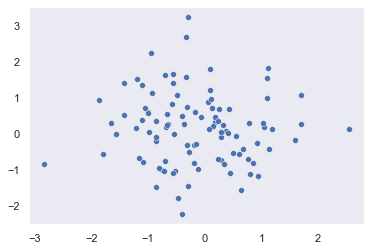

In [191]:
X = np.random.multivariate_normal(mean=[0, 0],cov = [[1, 0], [0, 1]],size=N)

ax=sns.scatterplot(data=X, x=X[:,0], y=X[:,1])
#sns.kdeplot(data=X, x=X[:,0], y=X[:,1],label='kde of MVN')


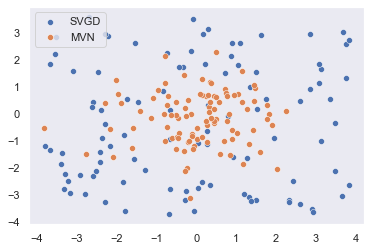

In [37]:


ax=sns.scatterplot(data=data, x=data[:,0], y=data[:,1],label='SVGD')
ax=sns.scatterplot(data=X, x=X[:,0], y=X[:,1],label='MVN')
#sns.kdeplot(data=data, x=data[:,0], y=data[:,1],label='kde of data')



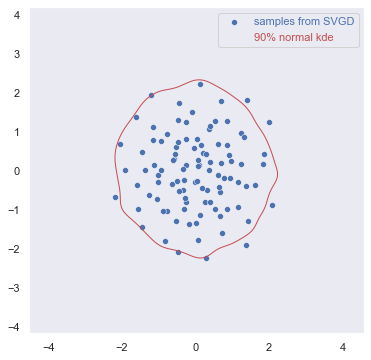

In [204]:
#Reasonably important TODO: Want to plot true 90% ellipse instead of just estimating it from data

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian
n = 3000
mean = [0, 0]
cov = [(1., 0.), (.0, 1.)]
rng = np.random.RandomState(0)
x, y = rng.multivariate_normal(mean, cov, n).T

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
#sns.scatterplot(x=x, y=y, s=5, color=".15")
#sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")

sns.scatterplot(data=data, x=data[:,0], y=data[:,1],color='b',label='samples from SVGD')

sns.kdeplot(x=x, y=y, levels=[0.1], color="r", linewidths=1,label='90% normal kde')

#sns.scatterplot(data=data, x=data[:,0], y=data[:,1],color='b',label='samples from SVGD')

plt.legend(labelcolor=['b','r'],loc=1)



In [ ]:
ax = sns.kdeplot(data,label='kde of data')
x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
x_pdf = np.linspace(x0, x1, 100)
y_pdf = scipy.stats.norm.pdf(x_pdf)

ax.plot(x_pdf, y_pdf, 'r', lw=2, label='normal pdf')                                                   
ax.legend()
